In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler

In [2]:
df = pd.read_csv('../Data/galway_rentals.txt', delimiter='\t')

In [3]:
df['price_cat'] = pd.cut(df['price_per_month'], 
                        bins=[0,1200,1500, 2000,np.inf],
                        labels=[1,2,3,4])

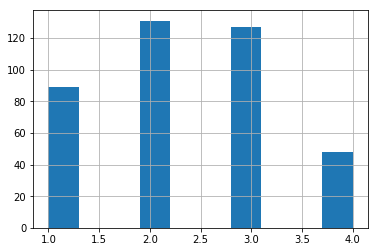

In [4]:
df['price_cat'].hist()

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in split.split(df, df['price_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
for i in (strat_train_set,strat_test_set):
    i.drop('price_cat', axis=1, inplace=True)
    
target = 'price_per_month'
features = list(strat_train_set.columns)[1:]

X_train_pre, y_train = strat_train_set[features], strat_train_set[target]
X_test_pre, y_test = strat_test_set[features], strat_test_set[target]

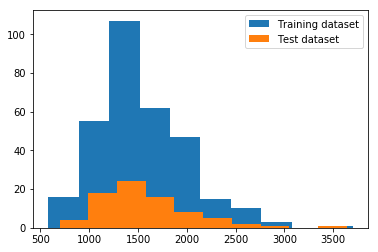

In [22]:
fig, ax = plt.subplots()
ax.hist(strat_train_set['price_per_month'], label='Training dataset')
ax.hist(strat_test_set['price_per_month'], label="Test dataset")
leg=ax.legend()

In [8]:
# Preprocessing - scaling and encoding

numeric_cols = ['distance_eyre_square', 'distance_salthill', 'distance_nuig', 'distance_gmit']

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])


full_pipeline = ColumnTransformer([
    ('numeric', num_pipeline, numeric_cols),
    ('ord', OrdinalEncoder(),['ber', 'floor']),
    ('cat', OneHotEncoder(), ['type', 'heating', 'balcony'])
],
    remainder= 'passthrough')
X_train = full_pipeline.fit_transform(X_train_pre)
X_test = full_pipeline.transform(X_test_pre)

In [23]:
# Creating the linear model
sgd_reg = SGDRegressor(max_iter =10000, tol=1e-3, penalty=None, eta0=0.001)
scores = cross_val_score(sgd_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10,)

In [24]:
rmse_scores = np.sqrt(-scores)

In [25]:
sgd_reg.fit(X_train, y_train)
predictions = sgd_reg.predict(X_test)

In [26]:
print("Scores: ", rmse_scores)
print("Mean scores: ", np.mean(rmse_scores))
print("Std scores: ", np.std(rmse_scores))

Scores:  [248.28750051 312.66850122 273.03051123 330.34198096 317.47645288
 246.05890651 331.19247634 226.88902139 308.66904824 331.10103955]
Mean scores:  292.5715438825456
Std scores:  38.08743081493283


In [28]:
lin_mse = mean_squared_error(y_test, predictions)

In [29]:
lin_rmse = np.sqrt(lin_mse)

In [30]:
lin_rmse

300.6979394134289